In [1]:
import os
import json
from glob import glob
from itertools import permutations, product
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

import gym
import compiler_gym

import torch
from torch import nn
from torch.distributions import Categorical

import networkx as nx
import torch_geometric as pyg
import torch_geometric.nn as pygnn
import torch_geometric.transforms as T

from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DATA_DIR = '/home/anthony/graph-data'

env = compiler_gym.make(     
    "llvm-ic-v0",                          
    reward_space="IrInstructionCountOz"
)
uris = list(env.datasets["benchmark://cbench-v1"].benchmark_uris())
data_ids = [j.split('//')[1].replace('/', '_') for j in uris]

with open('/home/anthony/state-transition-vocab.json') as fp:
    vocab = json.load(fp)

In [3]:
transform = T.Compose([
    T.RandomLinkSplit(
        num_val=0.2, num_test=0.2, is_undirected=False,
        split_labels=True, # must be true
        add_negative_train_samples=False
    ),
    T.ToDevice(device),
])

In [4]:
def load_pyg():
    l = []
    for i in data_ids:
        t = torch.load(f'{DATA_DIR}/{i}.pt')
        l.append(t)
        
    return l

pyg_graphs = load_pyg()

In [5]:
train_subgraphs, val_subgraphs, test_subgraphs = [], [], []
for g in pyg_graphs:
    i, j, k = transform(g)
    train_subgraphs.append(i)
    val_subgraphs.append(j)
    test_subgraphs.append(k)

In [12]:
train_subgraphs

[Data(edge_index=[2, 134395], label=[127169], id=[223991], x=[127169, 2], edge_attr=[134395, 2], pos_edge_label=[134395], pos_edge_label_index=[2, 134395]),
 Data(edge_index=[2, 1836], label=[1739], id=[3058], x=[1739, 2], edge_attr=[1836, 2], pos_edge_label=[1836], pos_edge_label_index=[2, 1836]),
 Data(edge_index=[2, 109017], label=[102545], id=[181693], x=[102545, 2], edge_attr=[109017, 2], pos_edge_label=[109017], pos_edge_label_index=[2, 109017]),
 Data(edge_index=[2, 128227], label=[121387], id=[213709], x=[121387, 2], edge_attr=[128227, 2], pos_edge_label=[128227], pos_edge_label_index=[2, 128227]),
 Data(edge_index=[2, 1428], label=[1351], id=[2380], x=[1351, 2], edge_attr=[1428, 2], pos_edge_label=[1428], pos_edge_label_index=[2, 1428]),
 Data(edge_index=[2, 8986], label=[8684], id=[14976], x=[8684, 2], edge_attr=[8986, 2], pos_edge_label=[8986], pos_edge_label_index=[2, 8986]),
 Data(edge_index=[2, 129006], label=[122152], id=[215010], x=[122152, 2], edge_attr=[129006, 2], po

In [39]:
def draw(x):
    plt.figure(figsize=(15,15)) 
    x = pyg.utils.to_networkx(x)
    nx.draw_spring(x, node_size=8)
    plt.show()

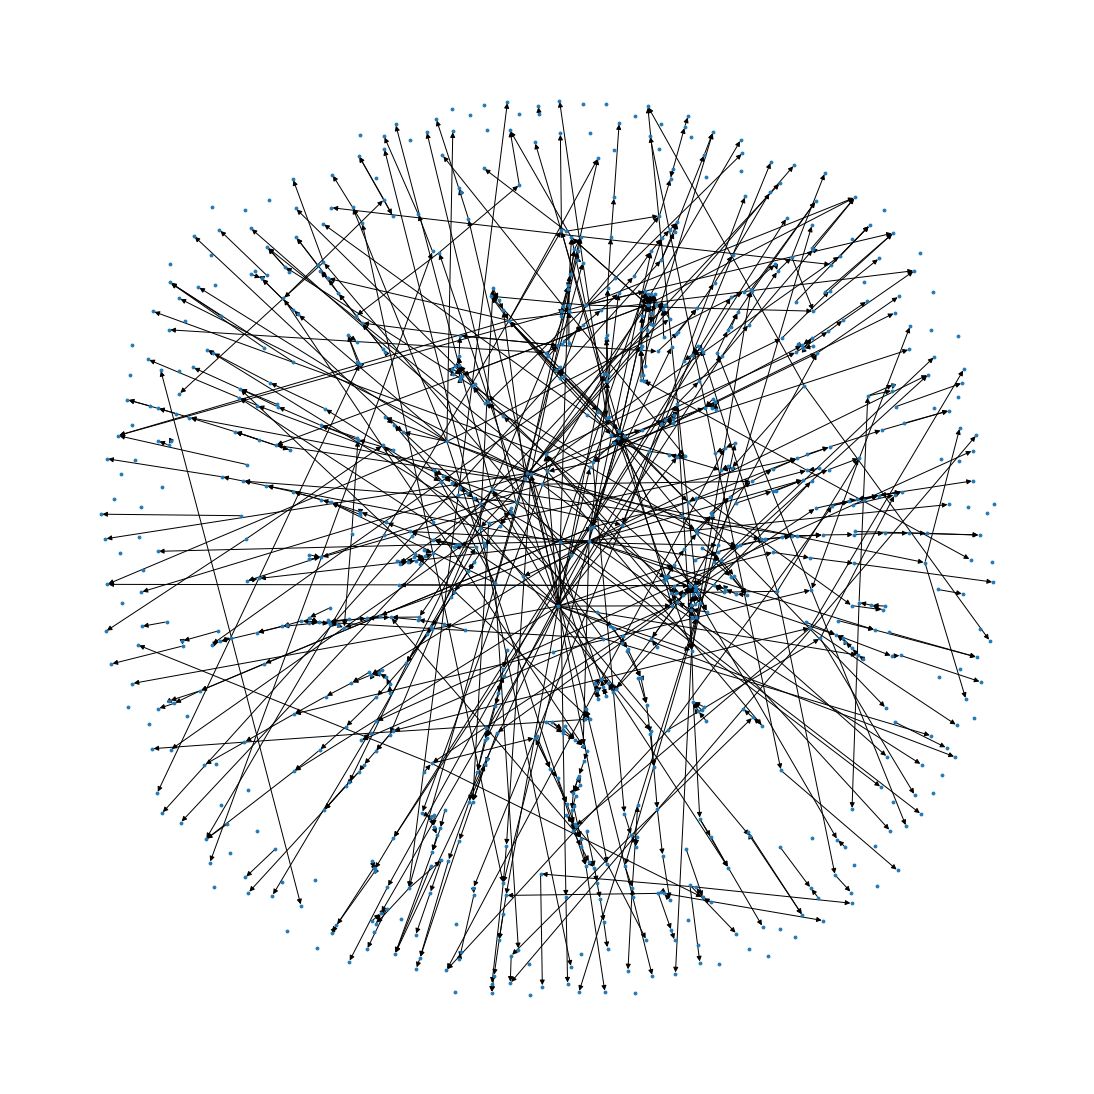

In [40]:
draw(train_subgraphs[11])

In [43]:
val_subgraphs[11].num_nodes

891

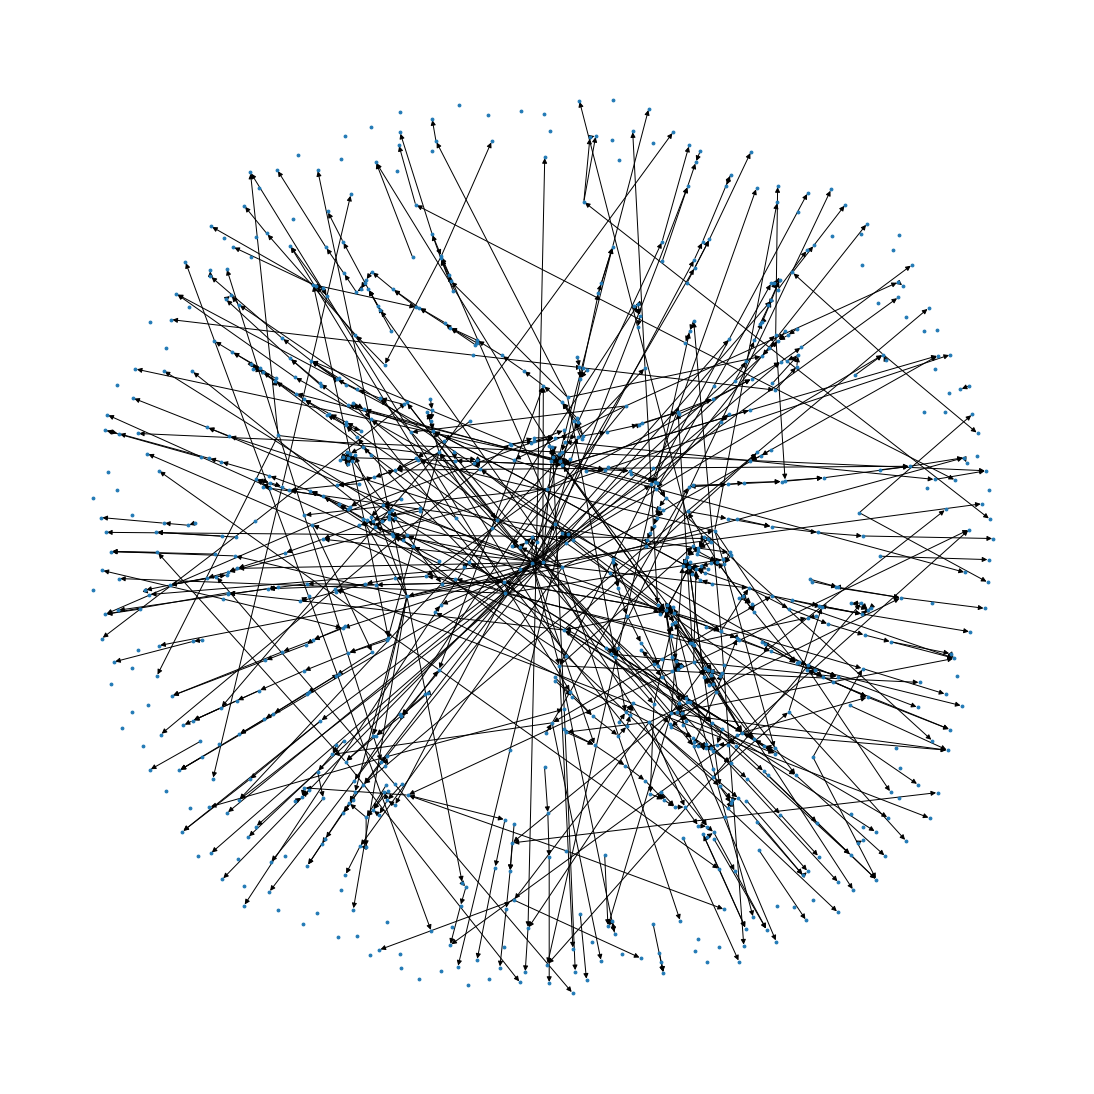

In [41]:
draw(val_subgraphs[11])

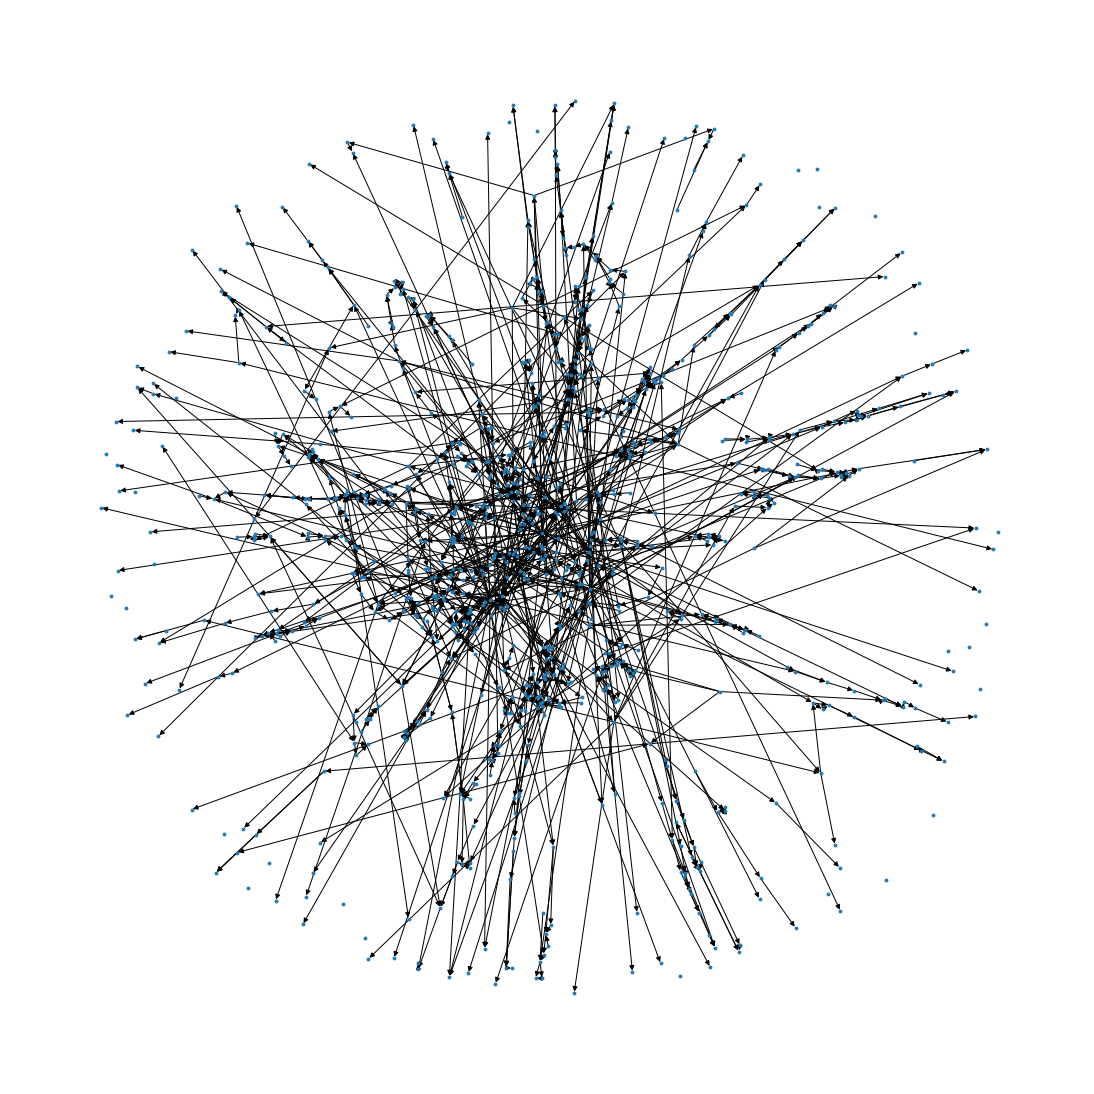

In [42]:
draw(test_subgraphs[11])

## Autoencoder

In [10]:
class NodeEncoder(nn.Module):
    def __init__(self, text_dim, type_dim=3):
        super(NodeEncoder, self).__init__()
        # must add 1 for OOV
        text_dim += 1
        self.text_embedding = nn.Embedding(text_dim, 128)
        self.type_embedding = nn.Embedding(type_dim, 3)
        self.node_dim = \
            self.text_embedding.embedding_dim + self.type_embedding.embedding_dim

    def forward(self, x) -> torch.Tensor:
        text, type_ = x[..., 0], x[..., 1]

        text = text.long()
        text = self.text_embedding(text)

        type_ = type_.long()
        type_ = self.type_embedding(type_)

        x = torch.cat([text, type_], axis=-1)

        return x


class PositionEmbedding(nn.Module):
    def __init__(self, bin=16.0, pos_max=4096):
        # $e_pos$ : max of position
        # https://github.com/ChrisCummins/phd/blob/aab7f16bd1f3546f81e349fc6e2325fb17beb851/programl/models/ggnn/messaging_layer.py#L38
        super().__init__()
        self.pos_max = pos_max
        rg = torch.arange(0.0, pos_max, bin, dtype=float)
        inv_freq = 1 / (10000 ** (rg / pos_max))
        self.inv_freq = inv_freq  # .cuda()

    def forward(self, positions, dpad: int = 0):
        """Transformer-like sinusoidal positional embeddings.

        Args:
          positions: 1d long Tensor of positions.
          dpad: Padding zeros to concatenate to embedding vectors.
        """
        # inv_freq = self.inv_freq.unsqueeze(0).repeat(
        #     positions.shape[0], 1, 1
        # )
        self.inv_freq = self.inv_freq.to(positions.device)  # TODO: maybe bottlenectk

        sinusoid_inp = torch.outer(positions, self.inv_freq)
        pos_emb = torch.cat(
            (torch.sin(sinusoid_inp), torch.cos(sinusoid_inp)),
            dim=1
        )

        if dpad > 0:
            in_length = positions.size()[0]
            pad = torch.zeros((in_length, dpad))
            pos_emb = torch.cat([pos_emb, pad], dim=1)
            assert torch.all(
                pos_emb[:, -1] == torch.zeros(in_length)
            ), f"test failed. pos_emb: \n{pos_emb}"
        
        return pos_emb.float()


class EdgeEncoder(nn.Module):
    def __init__(self, bin=128.0, flow_dim=3):
        super(EdgeEncoder, self).__init__()

        self.flow_embedding = nn.Embedding(flow_dim, 3)
        self.pos_embedding = PositionEmbedding(bin=bin)
        self.edge_dim = \
            self.flow_embedding.embedding_dim + \
            self.pos_embedding.inv_freq.shape[0]

    def forward(self, x) -> torch.Tensor:
        flow, pos = x[..., 0], x[..., 1]

        flow = flow.long()
        flow = self.flow_embedding(flow)

        pos = pos.long()
        pos = self.pos_embedding(pos)

        x = torch.cat([flow, pos], axis=-1)

        return x
    
edge_dim = 67
class GCNEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.node_encoder = NodeEncoder(len(vocab))
        self.edge_encoder = EdgeEncoder()
        
        # self.conv1 = pygnn.GATConv(in_channels, 2 * out_channels, edge_dim=edge_dim)
        # self.conv2 = pygnn.GATConv(2 * out_channels, out_channels, edge_dim=edge_dim)
        # self.conv1 = pygnn.GeneralConv(in_channels, 2 * out_channels, in_edge_channels=edge_dim)
        # self.conv2 = pygnn.GeneralConv(2 * out_channels, out_channels, in_edge_channels=edge_dim)
        # edge_dim = self.ee.edge_dim
        self.c1 = pygnn.GATv2Conv(-1, 32, edge_dim=edge_dim)
        # self.p1 = pygnn.TopKPooling(32, ratio=0.6)
        self.c2 = pygnn.GATv2Conv(32, 16, edge_dim=edge_dim)
        # self.p2 = pygnn.TopKPooling(16, ratio=0.6)
        
    def forward(self, x, edge_index, edge_attr):
        x = x.float()
        edge_index = edge_index.long()
        edge_attr = edge_attr.float()

        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
 
        x = self.c1(x, edge_index, edge_attr)
        x = self.c2(x, edge_index, edge_attr)
        
        return x
    
heads = 1
class VGCNEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.node_encoder = ne
        self.edge_encoder = ee
 
        self.c1 = pygnn.GATv2Conv(-1, 32, edge_dim=edge_dim, heads=heads)
    
        self.mu = pygnn.GATv2Conv(32, 16, edge_dim=edge_dim, heads=heads)
        self.sigma = pygnn.GATv2Conv(32, 16, edge_dim=edge_dim, heads=heads)
        
    def forward(self, x, edge_index, edge_attr):
        x = x.float()
        edge_index = edge_index.long()
        edge_attr = edge_attr.float()

        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
 
        x = self.c1(x, edge_index, edge_attr)
    
        mu = self.mu(x, edge_index, edge_attr)
        sigma = self.sigma(x, edge_index, edge_attr)
        
        return mu, sigma

    
def train(data):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index, data.edge_attr)
    loss = model.recon_loss(z, data.pos_edge_label_index)
    if variational:
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index, data.edge_attr)
    print(z)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

variational = False
if variational:
    model = pygnn.VGAE(VGCNEncoder())
else:
    model = pygnn.GAE(GCNEncoder())
    
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_loader = pyg.loader.DataLoader(train_subgraphs)
val_loader = pyg.loader.DataLoader(val_subgraphs)
test_loader = pyg.loader.DataLoader(test_subgraphs)

epochs = 16
for train_data, val_data, test_data in zip(train_loader, val_loader, test_loader):
    for epoch in range(1, epochs + 1):
        loss = train(train_data)
        auc, ap = test(val_data)
        print(f'Epoch: {epoch:03d} TRAIN Loss: {loss:.4f} VAL AUC: {auc:.4f}, AP: {ap:.4f}')

    auc, ap = test(test_data)
    print(f'TEST AUC: {auc:.4f}, AP: {ap:.4f}') 
print('end')

tensor([[ 1.3660,  0.7183,  1.0288,  ...,  1.6954,  1.1853, -1.0744],
        [ 1.3519,  0.7982,  1.0559,  ...,  1.5948,  1.1034, -0.9766],
        [ 1.3924,  0.8439,  1.0204,  ...,  1.4820,  1.0958, -0.9257],
        ...,
        [ 1.3478,  1.1139,  1.1088,  ...,  1.1387,  0.8213, -0.5953],
        [ 1.3478,  1.1139,  1.1088,  ...,  1.1387,  0.8213, -0.5953],
        [ 1.3478,  1.1139,  1.1088,  ...,  1.1387,  0.8213, -0.5953]],
       device='cuda:0')
Epoch: 001 TRAIN Loss: 34.5388 VAL AUC: 0.5000, AP: 0.5000
tensor([[ 1.3660,  0.7183,  1.0288,  ...,  1.6954,  1.1853, -1.0744],
        [ 1.3519,  0.7982,  1.0559,  ...,  1.5948,  1.1034, -0.9766],
        [ 1.3924,  0.8439,  1.0204,  ...,  1.4820,  1.0958, -0.9257],
        ...,
        [ 1.3478,  1.1139,  1.1088,  ...,  1.1387,  0.8213, -0.5953],
        [ 1.3478,  1.1139,  1.1088,  ...,  1.1387,  0.8213, -0.5953],
        [ 1.3478,  1.1139,  1.1088,  ...,  1.1387,  0.8213, -0.5953]],
       device='cuda:0')
Epoch: 002 TRAIN Loss: 34

KeyboardInterrupt: 